In [1]:
import itertools as it
import os

from iterpop import iterpop as ip
from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats
import seaborn as sns
from teeplot import teeplot as tp


In [2]:
# prints metadata about notebook runtime
nbm.print_metadata()


context: ci
hostname: fv-az1380-989
interpreter: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
nbcellexec: null
nbname: perfect-tree-phylometrics
nbpath: /home/runner/work/hstrat-evolutionary-inference/hstrat-evolutionary-inference/binder/perfect-tree-phylometrics.ipynb
revision: null
session: fe9d2f02-3e9b-4436-88b8-a3da42dece8c
timestamp: 2024-03-22T21:41:48Z00:00


IPython==8.13.0
keyname==0.5.2
yaml==6.0
iterpop==0.4.1
matplotlib==3.7.1
nbmetalog==0.2.6
numpy==1.21.6
pandas==1.3.5
scipy==1.7.3
seaborn==0.12.1
teeplot==0.5.0
re==2.2.1
comm==0.2.2
logging==0.5.1.2
psutil==5.9.8
zmq==24.0.1
json==2.0.9
ipykernel==6.29.3


In [3]:
df = pd.read_csv("https://osf.io/2xuyg/download")
dfdigest = np.bitwise_xor.reduce(
    pd.util.hash_pandas_object(df),
)
print("{:x}".format(dfdigest))
df


a78d74bbfd66538a


,a,epoch,mut_distn,num_generations,num_islands,num_niches,p_island_migration,p_niche_invasion,population_size,replicate,...,variance_pairwise_distance,variance_pairwise_distance_branch_only,mrca_depth,sackin_index,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,resolution,subsampling-fraction,trie-postprocess
0,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,36,...,287183.364388,14.043593,0,27223,1210.960392,3.210256e+06,504052.827821,NaN,NaN,NaN
1,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,37,...,348528.257947,14.320022,0,31933,1056.875368,3.230868e+06,865335.516754,NaN,NaN,NaN
2,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,6,...,229751.399043,13.258748,0,28964,1151.469136,3.171146e+06,727694.363524,NaN,NaN,NaN
3,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,20,...,228292.620676,10.335814,0,23933,1289.021227,3.339854e+06,436404.480172,NaN,NaN,NaN
4,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,34,...,245030.093866,12.832336,0,26307,1217.977803,3.237385e+06,540209.820753,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109195,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,10,...,24.562416,24.562416,1,3305,99.163609,3.242650e+04,282.320163,30.0,0.01,naive
109196,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,16,...,17.300466,17.300466,0,2923,1893.146789,6.190590e+05,250803.885040,100.0,0.01,rollback
109197,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,1,...,88.702783,88.702783,1,717008,5.744125,1.882235e+05,6.163179,100.0,1.00,rollback
109198,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,10,...,25.685331,25.685331,0,516453,28.659882,9.391270e+05,116.954707,3.0,1.00,naive


In [4]:
# phylometrics whittled down to descriptive, non-redundant set
phylometrics = [
    #     'diversity',
    "colless_like_index",
    #     'average_depth',
    #     'average_origin_time',
    #     'average_origin_time_normalized',
    #     'max_depth',
    "mean_pairwise_distance",
    #     'mean_pairwise_distance_branch_only',
    #     'num_active',
    "sum_distance",
    # "num_ancestors",
    #     'num_outside',
    #     'num_roots',
    #     'num_taxa',
    #     'phylogenetic_diversity',
    #     'sum_pairwise_distance',
    #     'sum_pairwise_distance_branch_only',
    #     'total_orgs',
    #     'tree_size',
    #     'variance_pairwise_distance',
    #     'variance_pairwise_distance_branch_only',
    #     'mrca_depth',
    #     'sackin_index',
    "mean_evolutionary_distinctiveness",
    #     'sum_evolutionary_distinctiveness',
    #     'variance_evolutionary_distinctiveness',
]


In [5]:
methodological_variables = [
    "resolution",
]


In [6]:
evolutionary_variables = [
    "num_islands",
    "num_niches",
    "tournament_size",
    "p_niche_invasion",
]


In [7]:
sensitivity_analysis_variables = [
    "epoch",
    "mut_distn",
]


In [8]:
fixed_variables = [
    "num_generations",  # homogeneous (num generations per epoch)
    "p_island_migration",  # homogeneous
    "population_size",  # homogeneous
    "subsampling-fraction",  # only use 1.0
    "trie-postprocess",  # just use naive postprocessing for now
]


In [9]:
# ensure fixed variables
df = df[
    (df["p_island_migration"] == 0.01)
    & ((df["subsampling-fraction"] == 1.0) | df["subsampling-fraction"].isna())
    & ((df["trie-postprocess"] == "naive") | df["trie-postprocess"].isna())
].copy()

for fixed_variable in fixed_variables:
    assert len(df[fixed_variable].dropna().unique()) == 1

df


,a,epoch,mut_distn,num_generations,num_islands,num_niches,p_island_migration,p_niche_invasion,population_size,replicate,...,variance_pairwise_distance,variance_pairwise_distance_branch_only,mrca_depth,sackin_index,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,resolution,subsampling-fraction,trie-postprocess
0,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,36,...,287183.364388,14.043593,0,27223,1210.960392,3210256.0,504052.827821,NaN,NaN,NaN
1,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,37,...,348528.257947,14.320022,0,31933,1056.875368,3230868.0,865335.516754,NaN,NaN,NaN
2,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,6,...,229751.399043,13.258748,0,28964,1151.469136,3171146.0,727694.363524,NaN,NaN,NaN
3,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,20,...,228292.620676,10.335814,0,23933,1289.021227,3339854.0,436404.480172,NaN,NaN,NaN
4,consolidated-phylogeny,2,np.random.exponential,32768,1024,4,0.01,3.051758e-08,32768,34,...,245030.093866,12.832336,0,26307,1217.977803,3237385.0,540209.820753,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109156,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,25,...,86.927779,86.927779,1,724151,6.498184,212932.5,6.463885,100.0,1.0,naive
109158,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,19,...,41.519441,41.519441,1,564013,4.646164,152245.5,2.874790,30.0,1.0,naive
109170,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,17,...,72.132664,72.132664,1,685644,5.576447,182729.0,3.720116,30.0,1.0,naive
109171,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,3,...,29.663459,29.663459,0,527010,29.281845,959507.5,121.981043,3.0,1.0,naive


In [10]:
# exclude extraneous variable values
df = df[(df["a"] == "collapsed-phylogeny")].copy()

df


,a,epoch,mut_distn,num_generations,num_islands,num_niches,p_island_migration,p_niche_invasion,population_size,replicate,...,variance_pairwise_distance,variance_pairwise_distance_branch_only,mrca_depth,sackin_index,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,resolution,subsampling-fraction,trie-postprocess
50,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,0.000003,32768,20,...,30.794793,30.794793,1,591511,78.882446,2584820.0,1348.379396,NaN,NaN,NaN
51,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,0.000003,32768,4,...,27.305316,27.305316,1,570110,81.707306,2677385.0,1030.406615,NaN,NaN,NaN
52,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,0.000003,32768,41,...,26.027820,26.027820,0,548025,83.217377,2726867.0,1170.361609,NaN,NaN,NaN
53,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,0.000003,32768,47,...,27.705938,27.705938,0,559117,86.538544,2835695.0,1284.142442,NaN,NaN,NaN
54,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,0.000003,32768,15,...,28.664163,28.664163,1,583153,76.277557,2499463.0,1545.456043,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104195,collapsed-phylogeny,2,np.random.exponential,32768,1024,4,0.01,0.000003,32768,35,...,27.905306,27.905306,0,557266,62.567078,2050198.0,699.189837,NaN,NaN,NaN
104196,collapsed-phylogeny,2,np.random.exponential,32768,1024,4,0.01,0.000003,32768,30,...,30.100132,30.100132,0,554954,54.291748,1779032.0,501.593774,NaN,NaN,NaN
104197,collapsed-phylogeny,2,np.random.exponential,32768,1024,4,0.01,0.000003,32768,49,...,31.654246,31.654246,0,549085,61.928589,2029276.0,1052.942164,NaN,NaN,NaN
104198,collapsed-phylogeny,2,np.random.exponential,32768,1024,4,0.01,0.000003,32768,42,...,23.908626,23.908626,0,532354,65.404114,2143162.0,870.762049,NaN,NaN,NaN


In [11]:
df["num_niches"].unique()


array([4, 1, 8])

In [12]:
df["num_islands"].unique()


array([1024,    1])

In [13]:
df["tournament_size"].unique()


array([2, 1, 4])

In [14]:
df["a"].unique()


array(['collapsed-phylogeny'], dtype=object)

In [15]:
df["regime"] = df.apply(
    lambda row: {
        (1, 1, 2, 3.0517578125e-08): "plain",
        (1, 1, 1, 3.0517578125e-08): "weak selection",
        (1, 1, 4, 3.0517578125e-08): "strong selection",
        (1, 1, 8, 3.0517578125e-08): "weak selection",
        (1, 4, 2, 3.0517578125e-06): "weak 4 niche ecology",
        (1, 4, 2, 3.0517578125e-08): "4 niche ecology",
        (1, 8, 2, 3.0517578125e-08): "8 niche ecology",
        (1024, 1, 2, 3.0517578125e-08): "spatial structure",
    }.get(
        tuple(
            row[
                [
                    "num_islands",
                    "num_niches",
                    "tournament_size",
                    "p_niche_invasion",
                ]
            ]
        ),
        np.nan,  # default
    ),
    axis="columns",
)
df = df.dropna(axis="index", subset=["regime"]).copy()
df["regime"].unique()


array(['weak 4 niche ecology', '4 niche ecology', 'weak selection',
       'plain', 'strong selection', 'spatial structure',
       '8 niche ecology'], dtype=object)

In [16]:
df[df["a"] == "collapsed-phylogeny"]["regime"].unique()


array(['weak 4 niche ecology', '4 niche ecology', 'weak selection',
       'plain', 'strong selection', 'spatial structure',
       '8 niche ecology'], dtype=object)

# Phylometrics by Regime, Perfect Data


In [17]:
melted_df = df[(df["a"] == "collapsed-phylogeny")].melt(
    id_vars=(
        evolutionary_variables
        + methodological_variables
        + sensitivity_analysis_variables
        + ["regime"]
    ),
    value_vars=phylometrics,
)
melted_df["phylometric"] = melted_df["variable"]
melted_df


,num_islands,num_niches,tournament_size,p_niche_invasion,resolution,epoch,mut_distn,regime,variable,value,phylometric
0,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak 4 niche ecology,colless_like_index,346237.149255,colless_like_index
1,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak 4 niche ecology,colless_like_index,393531.329296,colless_like_index
2,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak 4 niche ecology,colless_like_index,358279.386159,colless_like_index
3,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak 4 niche ecology,colless_like_index,435516.244222,colless_like_index
4,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak 4 niche ecology,colless_like_index,378408.625158,colless_like_index
...,...,...,...,...,...,...,...,...,...,...,...
8395,1,1,1,3.051758e-08,NaN,0,np.random.exponential,weak selection,mean_evolutionary_distinctiveness,19.401215,mean_evolutionary_distinctiveness
8396,1,1,1,3.051758e-08,NaN,0,np.random.exponential,weak selection,mean_evolutionary_distinctiveness,19.637848,mean_evolutionary_distinctiveness
8397,1,1,4,3.051758e-08,NaN,0,np.random.exponential,strong selection,mean_evolutionary_distinctiveness,1.908936,mean_evolutionary_distinctiveness
8398,1,1,4,3.051758e-08,NaN,0,np.random.exponential,strong selection,mean_evolutionary_distinctiveness,1.918182,mean_evolutionary_distinctiveness


teeplots/./col=phylometric+epoch=0+mut_distn=np.random.exponential+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/./col=phylometric+epoch=0+mut_distn=np.random.exponential+viz=barplot+x=value+y=regime+ext=.png


teeplots/./col=phylometric+epoch=0+mut_distn=np.random.standard_normal+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/./col=phylometric+epoch=0+mut_distn=np.random.standard_normal+viz=barplot+x=value+y=regime+ext=.png


teeplots/./col=phylometric+epoch=2+mut_distn=np.random.exponential+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/./col=phylometric+epoch=2+mut_distn=np.random.exponential+viz=barplot+x=value+y=regime+ext=.png


teeplots/./col=phylometric+epoch=2+mut_distn=np.random.standard_normal+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/./col=phylometric+epoch=2+mut_distn=np.random.standard_normal+viz=barplot+x=value+y=regime+ext=.png


teeplots/./col=phylometric+epoch=7+mut_distn=np.random.exponential+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/./col=phylometric+epoch=7+mut_distn=np.random.exponential+viz=barplot+x=value+y=regime+ext=.png


teeplots/./col=phylometric+epoch=7+mut_distn=np.random.standard_normal+viz=barplot+x=value+y=regime+ext=.pdf


teeplots/./col=phylometric+epoch=7+mut_distn=np.random.standard_normal+viz=barplot+x=value+y=regime+ext=.png


teeplots/./col=phylometric+epoch=0+mut_distn=np.random.exponential+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/./col=phylometric+epoch=0+mut_distn=np.random.exponential+viz=boxplot+x=value+y=regime+ext=.png


teeplots/./col=phylometric+epoch=0+mut_distn=np.random.standard_normal+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/./col=phylometric+epoch=0+mut_distn=np.random.standard_normal+viz=boxplot+x=value+y=regime+ext=.png


teeplots/./col=phylometric+epoch=2+mut_distn=np.random.exponential+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/./col=phylometric+epoch=2+mut_distn=np.random.exponential+viz=boxplot+x=value+y=regime+ext=.png


teeplots/./col=phylometric+epoch=2+mut_distn=np.random.standard_normal+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/./col=phylometric+epoch=2+mut_distn=np.random.standard_normal+viz=boxplot+x=value+y=regime+ext=.png


teeplots/./col=phylometric+epoch=7+mut_distn=np.random.exponential+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/./col=phylometric+epoch=7+mut_distn=np.random.exponential+viz=boxplot+x=value+y=regime+ext=.png


teeplots/./col=phylometric+epoch=7+mut_distn=np.random.standard_normal+viz=boxplot+x=value+y=regime+ext=.pdf


teeplots/./col=phylometric+epoch=7+mut_distn=np.random.standard_normal+viz=boxplot+x=value+y=regime+ext=.png


teeplots/./col=phylometric+epoch=0+mut_distn=np.random.exponential+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/./col=phylometric+epoch=0+mut_distn=np.random.exponential+viz=violinplot+x=value+y=regime+ext=.png


teeplots/./col=phylometric+epoch=0+mut_distn=np.random.standard_normal+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/./col=phylometric+epoch=0+mut_distn=np.random.standard_normal+viz=violinplot+x=value+y=regime+ext=.png


teeplots/./col=phylometric+epoch=2+mut_distn=np.random.exponential+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/./col=phylometric+epoch=2+mut_distn=np.random.exponential+viz=violinplot+x=value+y=regime+ext=.png


teeplots/./col=phylometric+epoch=2+mut_distn=np.random.standard_normal+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/./col=phylometric+epoch=2+mut_distn=np.random.standard_normal+viz=violinplot+x=value+y=regime+ext=.png


teeplots/./col=phylometric+epoch=7+mut_distn=np.random.exponential+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/./col=phylometric+epoch=7+mut_distn=np.random.exponential+viz=violinplot+x=value+y=regime+ext=.png


teeplots/./col=phylometric+epoch=7+mut_distn=np.random.standard_normal+viz=violinplot+x=value+y=regime+ext=.pdf


teeplots/./col=phylometric+epoch=7+mut_distn=np.random.standard_normal+viz=violinplot+x=value+y=regime+ext=.png


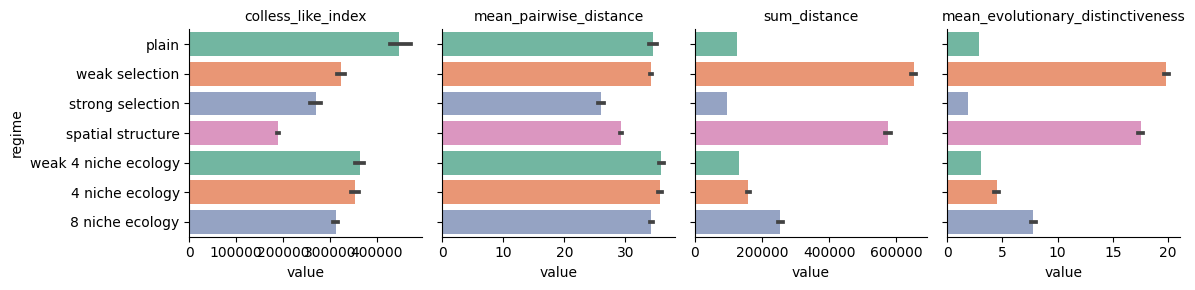

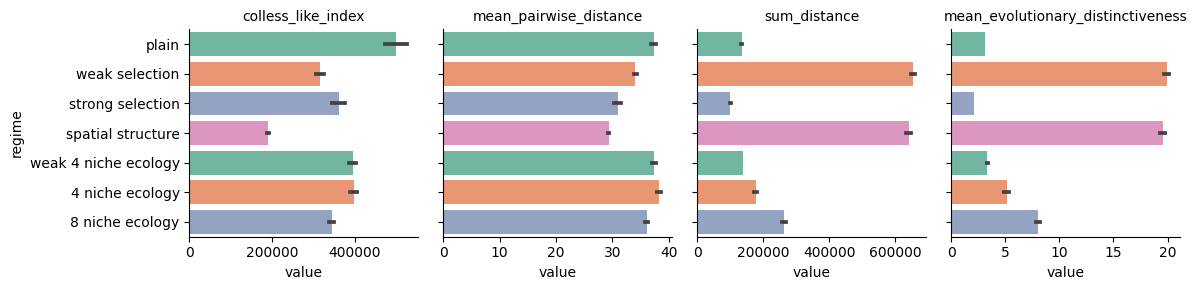

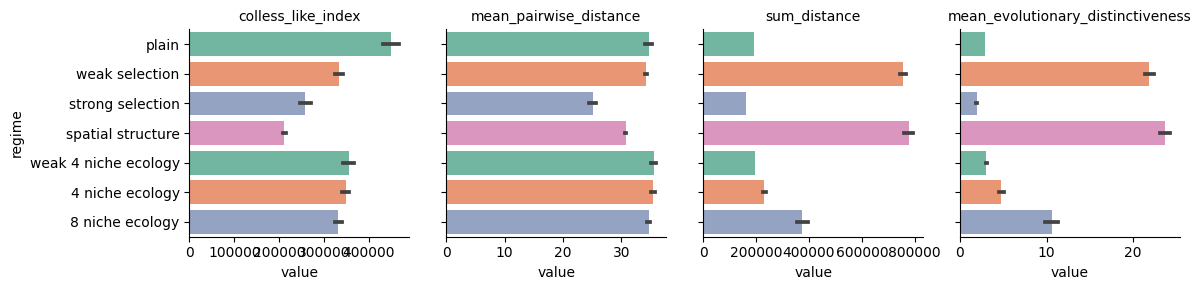

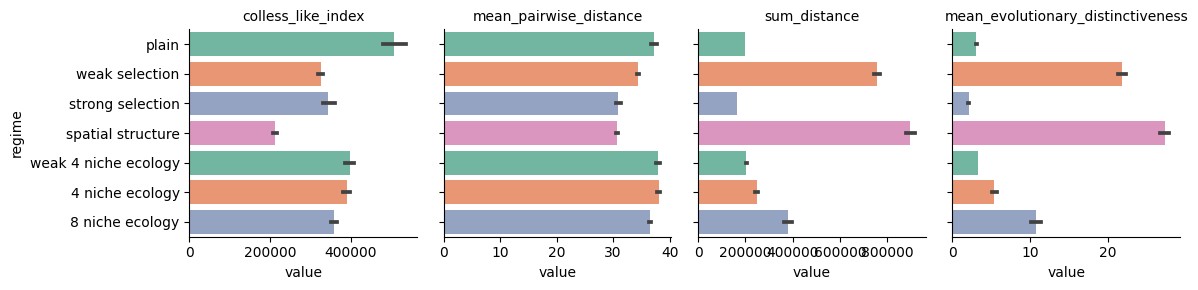

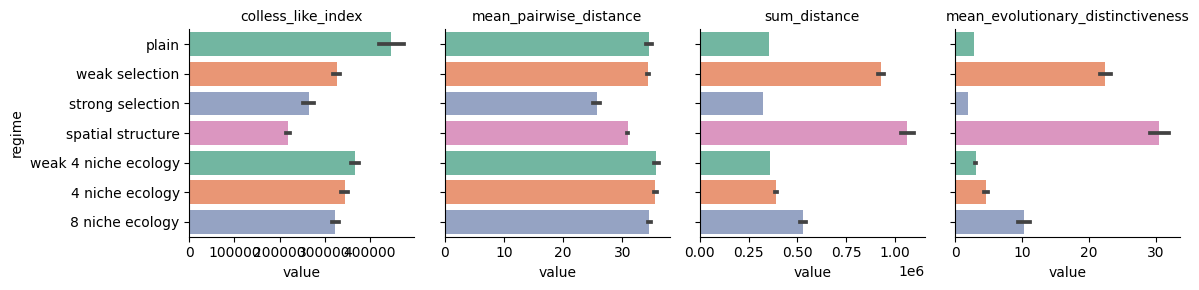

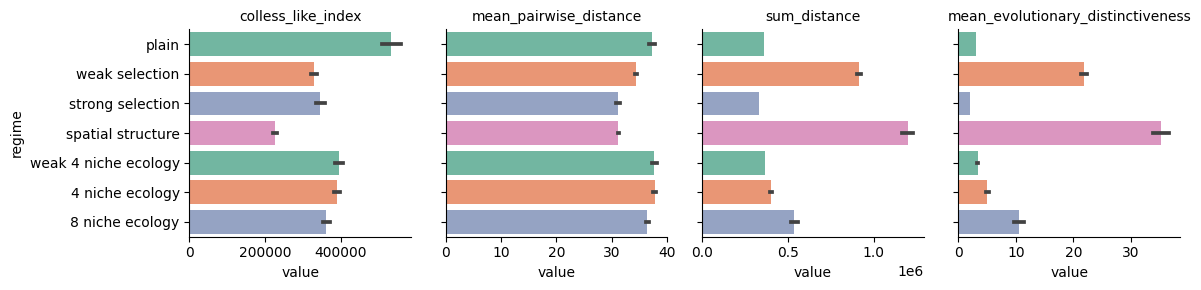

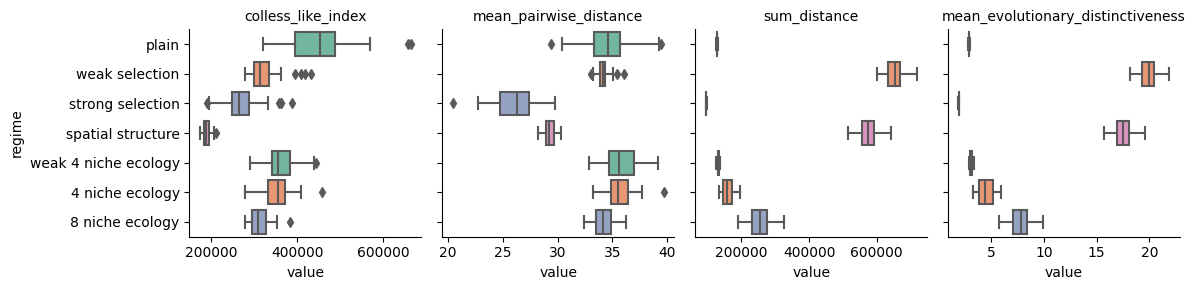

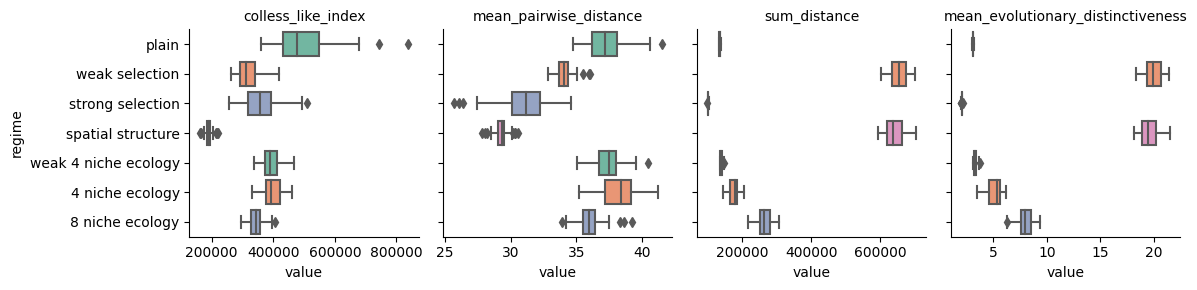

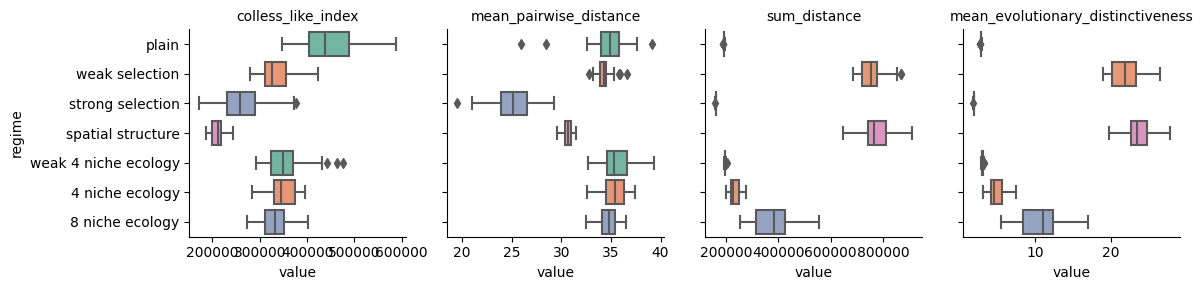

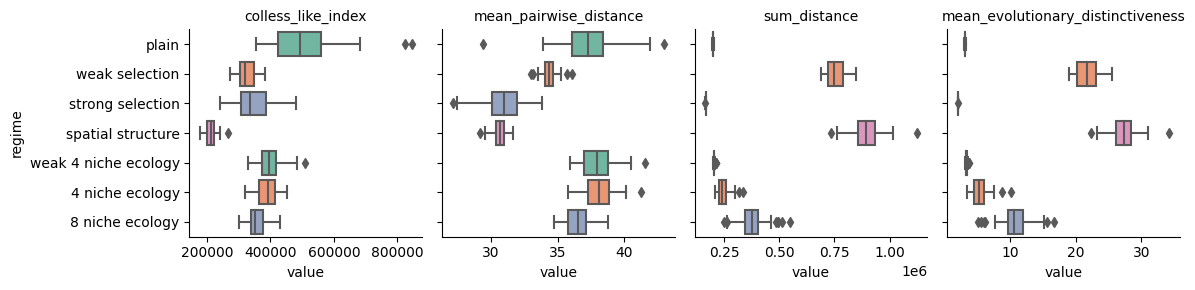

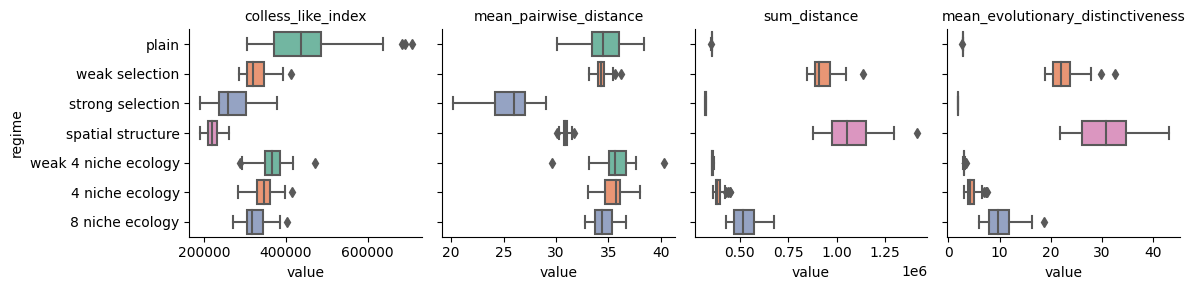

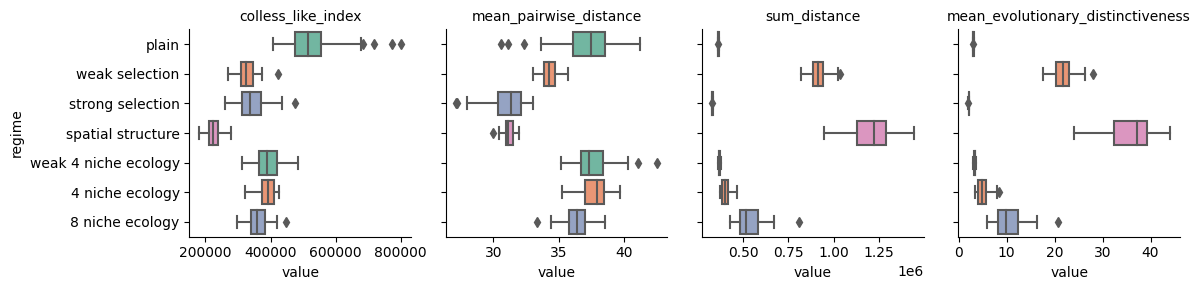

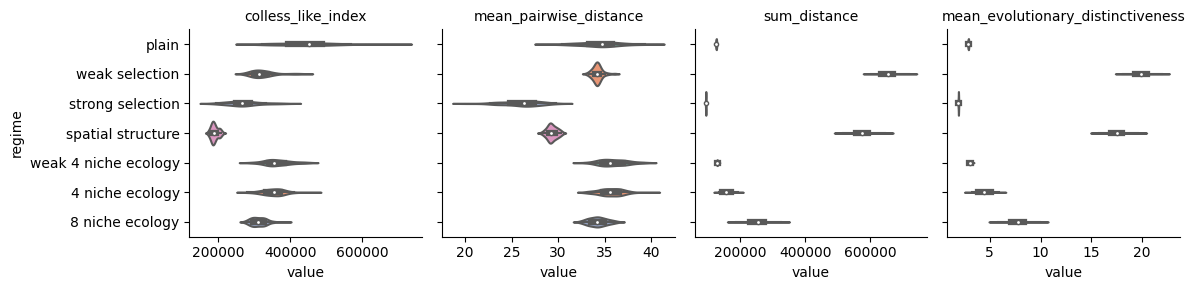

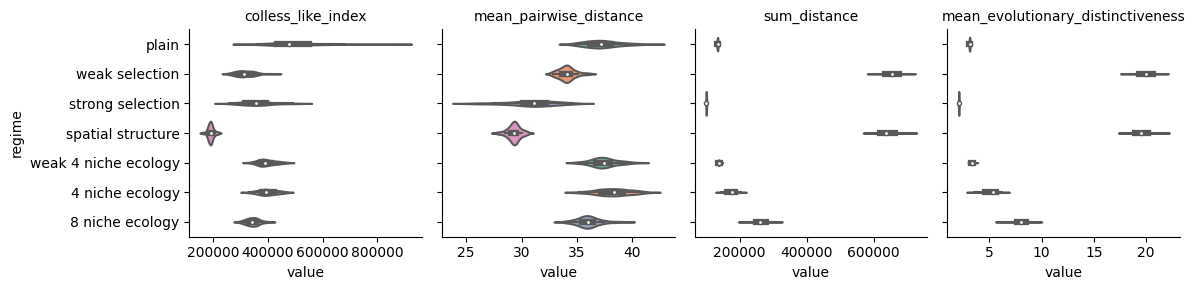

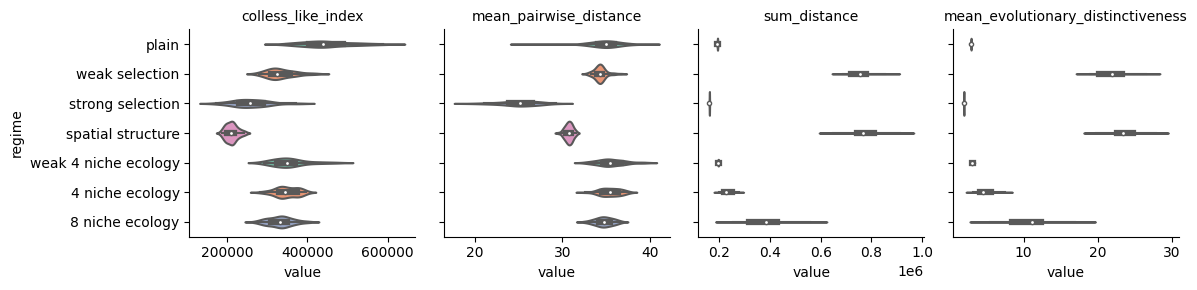

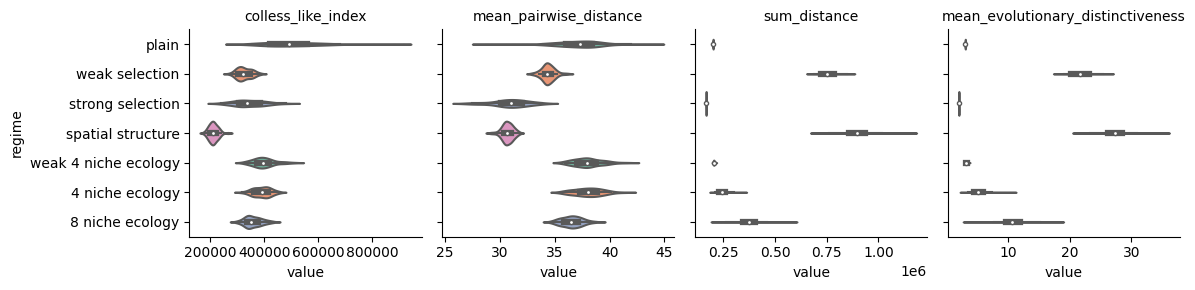

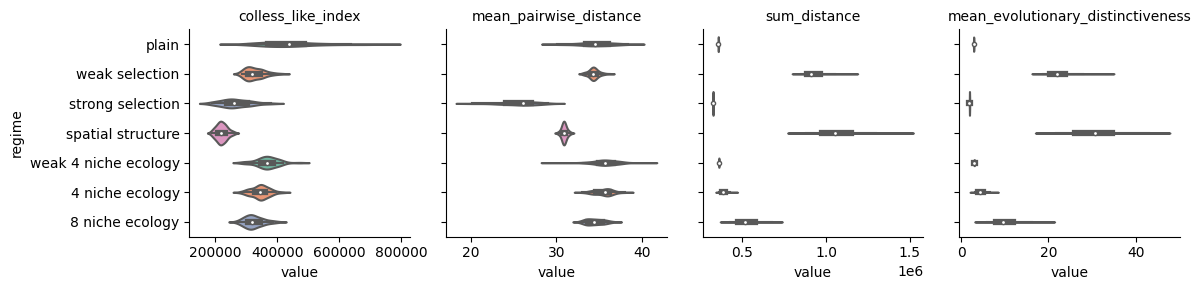

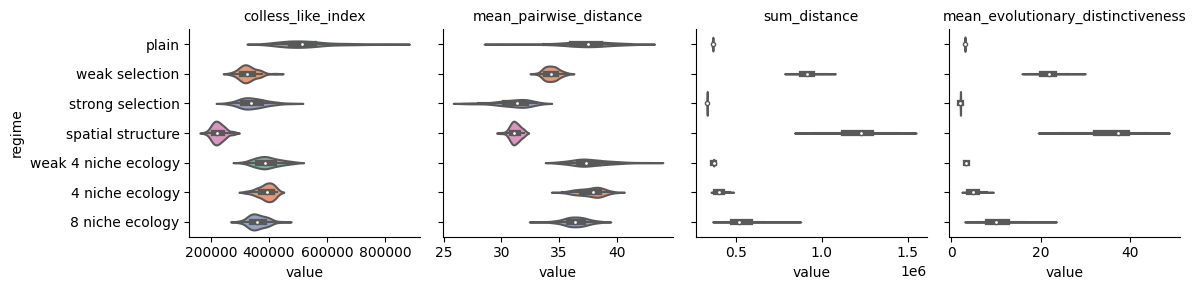

In [18]:
def make_do_plot(plotter):
    def do_plot(data, col, x, y):
        g = sns.FacetGrid(
            data,
            col=col,
            sharex=False,
        ).set_titles(template="{col_name}")
        g.map(
            plotter,
            x,
            y,
            order=[
                "plain",
                "weak selection",
                "strong selection",
                "spatial structure",
                "weak 4 niche ecology",
                "4 niche ecology",
                "8 niche ecology",
            ],
            palette=sns.color_palette("Set2", 4),
        )

    return do_plot


for viz, (group, group_df) in it.product(
    [
        sns.barplot,
        sns.boxplot,
        sns.violinplot,
    ],
    melted_df.groupby(sensitivity_analysis_variables),
):
    do_plot = make_do_plot(viz)
    do_plot.__name__ = viz.__name__
    tp.tee(
        do_plot,
        data=group_df,
        col="phylometric",
        x="value",
        y="regime",
        teeplot_outattrs=dict(
            zip(sensitivity_analysis_variables, group),
        ),
    )


# regime heatmap signatures


teeplots/./epoch=0+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/./epoch=0+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.png


teeplots/./epoch=0+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/./epoch=0+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.png


teeplots/./epoch=2+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/./epoch=2+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.png


teeplots/./epoch=2+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/./epoch=2+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.png


teeplots/./epoch=7+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.pdf


teeplots/./epoch=7+mut_distn=np.random.exponential+viz=heatmap+x=regime+y=phylometric+ext=.png


teeplots/./epoch=7+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.pdf
teeplots/./epoch=7+mut_distn=np.random.standard_normal+viz=heatmap+x=regime+y=phylometric+ext=.png


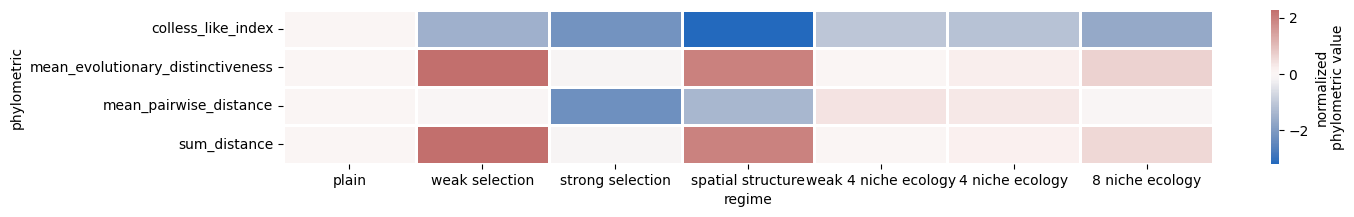

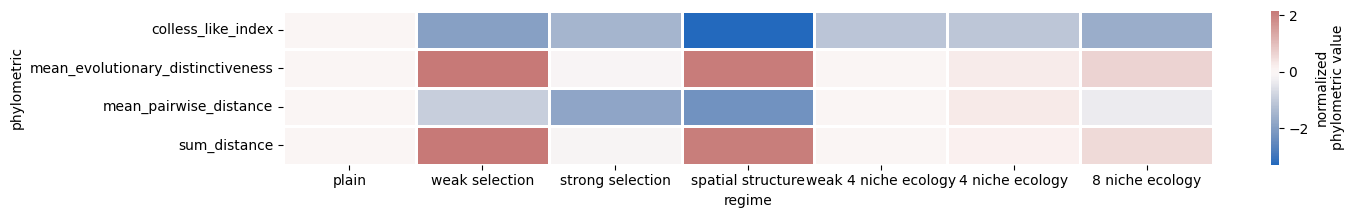

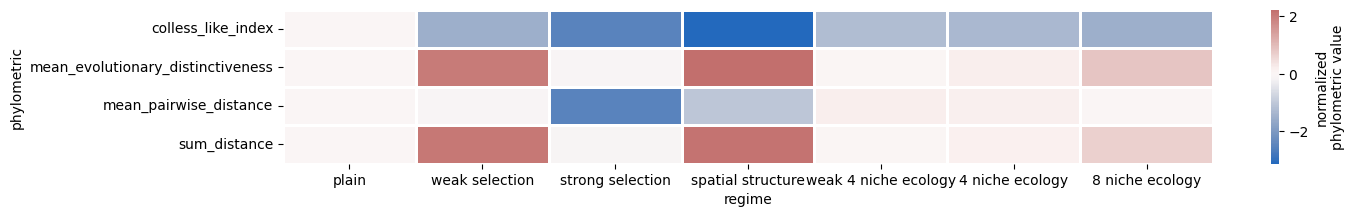

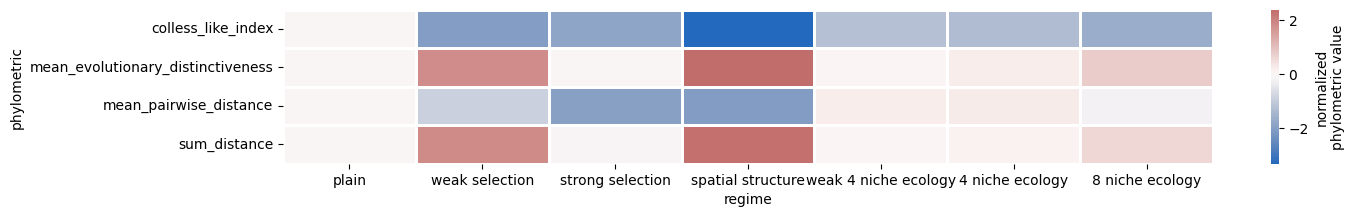

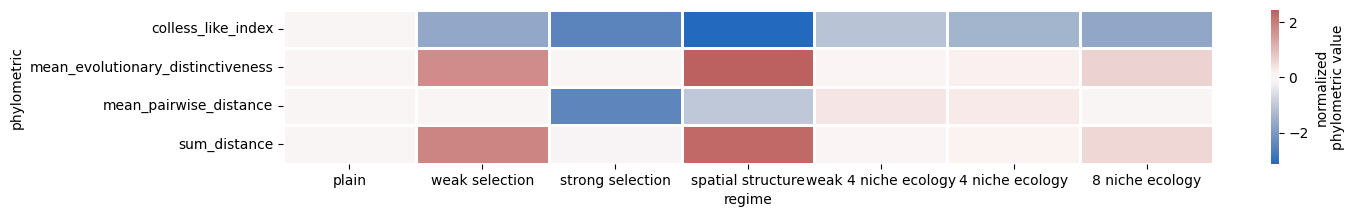

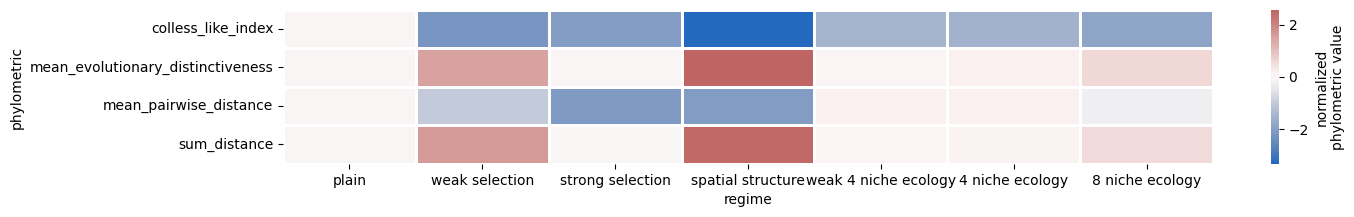

In [19]:
for (group, group_df) in df.groupby(sensitivity_analysis_variables):

    data = (
        group_df[(group_df["a"] == "collapsed-phylogeny")]
        .copy()
        .dropna(subset=["regime"])
    )

    data = data.groupby("regime").mean()

    plain_means = data.loc["plain"]
    plain_stds = data.std()

    # normalize to plain
    for phylometric in phylometrics:
        data[phylometric] = (
            data[phylometric] - plain_means[phylometric]
        ) / plain_stds[phylometric]

    data = data.reset_index(drop=False)
    data

    melted_df = data.melt(
        id_vars=["regime"],
        value_vars=phylometrics,
    )
    melted_df["phylometric"] = melted_df["variable"]
    melted_df

    fig, ax = plt.subplots(figsize=(15, 2))

    matrix = melted_df.pivot(
        index="phylometric",
        columns="regime",
        values="value",
    )
    matrix = matrix[
        sorted(
            matrix.columns,
            key=[
                "plain",
                "weak selection",
                "strong selection",
                "spatial structure",
                "weak 4 niche ecology",
                "4 niche ecology",
                "8 niche ecology",
            ].index,
        )
    ]

    tp.tee(
        sns.heatmap,
        matrix,
        linewidths=2,
        cmap=sns.color_palette("vlag", as_cmap=True),
        center=0,
        cbar_kws={"label": "normalized\nphylometric value"},
        teeplot_outattrs={
            **dict(
                zip(sensitivity_analysis_variables, group),
            ),
            **{
                "x": "regime",
                "y": "phylometric",
            },
        },
    )


# stats: kruskal-wallis


In [20]:
records = []
for phylometric in phylometrics:
    for group, group_df in df.groupby(
        sensitivity_analysis_variables, as_index=False
    ):
        kw_result, n = scipy_stats.kruskal(
            *(
                quality_series
                for quality, quality_series in group_df.groupby(["regime"])[
                    phylometric
                ]
            )
        ), ip.pophomogeneous(group_df.groupby(["regime"]).count()["a"])
        records.append(
            {
                **{
                    "n": n,
                    "N": len([*group_df.groupby(["regime"])]),
                    "phylometric": phylometric,
                },
                **dict(zip(["statistic", "p"], kw_result)),
                **dict(zip(sensitivity_analysis_variables, group)),
            }
        )

with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    out_df = (
        pd.DataFrame.from_records(records)
        .sort_values(
            sensitivity_analysis_variables,
        )
        .reset_index(drop=True)
    )
    display(out_df)
    os.makedirs("outdata", exist_ok=True)
    out_df.to_csv(
        "outdata/a=phylostatistics-comparison-between-regimes-kwallis+ext=.csv",
        index=False,
    )


,n,N,phylometric,statistic,p,epoch,mut_distn
0,50,7,colless_like_index,265.973064,1.576883e-54,0,np.random.exponential
1,50,7,mean_pairwise_distance,254.739684,3.980180e-52,0,np.random.exponential
2,50,7,sum_distance,339.976537,2.187512e-70,0,np.random.exponential
3,50,7,mean_evolutionary_distinctiveness,340.178419,1.979817e-70,0,np.random.exponential
4,50,7,colless_like_index,266.181427,1.423079e-54,0,np.random.standard_normal
5,50,7,mean_pairwise_distance,290.996267,6.944132e-60,0,np.random.standard_normal
6,50,7,sum_distance,334.967471,2.599197e-69,0,np.random.standard_normal
7,50,7,mean_evolutionary_distinctiveness,335.202247,2.314532e-69,0,np.random.standard_normal
8,50,7,colless_like_index,256.656035,1.549642e-52,2,np.random.exponential
9,50,7,mean_pairwise_distance,234.792635,7.262807e-48,2,np.random.exponential


# stats: wilcoxon all pairs


In [21]:
records = []
for phylometric in phylometrics:
    for group, group_df in df.groupby(
        sensitivity_analysis_variables, as_index=False
    ):
        for regime1, regime2 in it.combinations(
            group_df["regime"].unique(), 2
        ):
            kw_result, n = scipy_stats.wilcoxon(
                group_df[group_df["regime"] == regime1][phylometric],
                group_df[group_df["regime"] == regime2][phylometric],
            ), ip.pophomogeneous(group_df.groupby(["regime"]).count()["a"])
            records.append(
                {
                    **{
                        "regime1": regime1,
                        "regime2": regime2,
                        "n": n,
                        "phylometric": phylometric,
                    },
                    **dict(zip(["statistic", "p"], kw_result)),
                    **dict(zip(sensitivity_analysis_variables, group)),
                }
            )

with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    out_df = (
        pd.DataFrame.from_records(records)
        .sort_values(
            [*sensitivity_analysis_variables, "regime1", "regime2"],
        )
        .reset_index(drop=True)
    )
    display(out_df)
    os.makedirs("outdata", exist_ok=True)
    out_df.to_csv(
        "outdata/a=phylostatistics-comparison-between-regimes-allpairs-wilcox+ext=.csv",
        index=False,
    )


,regime1,regime2,n,phylometric,statistic,p,epoch,mut_distn
0,4 niche ecology,8 niche ecology,50,colless_like_index,82.0,8.212512e-08,0,np.random.exponential
1,4 niche ecology,8 niche ecology,50,mean_pairwise_distance,120.0,5.866172e-07,0,np.random.exponential
2,4 niche ecology,8 niche ecology,50,sum_distance,0.0,7.556929e-10,0,np.random.exponential
3,4 niche ecology,8 niche ecology,50,mean_evolutionary_distinctiveness,0.0,7.556929e-10,0,np.random.exponential
4,4 niche ecology,plain,50,colless_like_index,58.0,2.218011e-08,0,np.random.exponential
5,4 niche ecology,plain,50,mean_pairwise_distance,320.0,2.177312e-03,0,np.random.exponential
6,4 niche ecology,plain,50,sum_distance,0.0,7.556929e-10,0,np.random.exponential
7,4 niche ecology,plain,50,mean_evolutionary_distinctiveness,0.0,7.556929e-10,0,np.random.exponential
8,4 niche ecology,spatial structure,50,colless_like_index,0.0,7.556929e-10,0,np.random.exponential
9,4 niche ecology,spatial structure,50,mean_pairwise_distance,0.0,7.556929e-10,0,np.random.exponential
